In [1]:
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision.transforms import v2 as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def plot_image(tensor):
    plt.figure(figsize=(1.25, 1.25))
    plt.axis('off')
    plt.imshow(tensor.permute(1, 2, 0).numpy())

In [3]:
time = 1000
schedule = torch.linspace(1, 0.001, time)
def forward_diffuse(x, timestep, schedule=schedule):
    noise = torch.randn_like(x)
    alpha = schedule[timestep].view(-1, 1, 1, 1)
    return torch.sqrt(alpha) * x + torch.sqrt(1 - alpha) * noise, noise

In [4]:
class BackwardDiffuse(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()

        self.time_embed = nn.Linear(1, time_dim)
        self.fc1 = nn.Linear(128, 128)

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(128, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # # Embed the timestep using the learned embedding
        # t = t.unsqueeze(-1).float()  # Convert to float and ensure correct shape [batch_size, 1]
        # t_emb = self.time_embed(t)  # Pass through embedding layer [batch_size, time_dim]
        # t_emb = self.fc1(t_emb)

        # # Inject the timestep embedding into the model
        # # One way is to add it directly to the output of each conv layer
        # x = self.conv1(x)
        # x = x + t_emb.view(-1, 128, 1, 1)  # Reshape and add timestep embedding to the feature map
        # x = self.relu(x)

        # x = self.conv2(x)
        # x = x + t_emb.view(-1, 128, 1, 1)  # Inject timestep again at this layer
        # x = self.relu(x)

        # x = self.conv3(x)
        # x = x + t_emb.view(-1, 128, 1, 1)  # Inject timestep again at this layer
        # x = self.relu(x)

        # x = self.conv4(x)
        # x = self.relu(x)




        # t_emb = t.unsqueeze(-1).float()  # Shape: [batch_size, 1]
        
        # # Expand t_emb to match the shape of x. 
        # # If x has shape [batch_size, channels, height, width], expand t_emb to [batch_size, 1, height, width]
        # t_emb = t_emb.view(-1, 1, 1, 1).expand(-1, 1, x.shape[2], x.shape[3])  # Expand to match spatial dimensions
        
        # # Now concatenate along the channel dimension
        # x = torch.cat([x, t_emb], dim=1)  # Concatenate along channel dimension

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.conv8(x)
        return x

In [5]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
transform = T.Compose([
    T.ToImage(),
    # T.Resize(size=(32, 32), antialias=True),
    T.ToDtype(torch.float32, scale=True),
    # T.Normalize(mean=mean, std=std),
])

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform

train_data = datasets.CIFAR10(
    root="data",
    download=True,
    transform=transform
)

train_loader = DataLoader(dataset=train_data, batch_size=512, shuffle=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5055488..2.2681346].


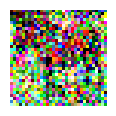

In [7]:
plot_image(forward_diffuse(train_data[7][0], 200)[0][0])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BackwardDiffuse()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(params=model.parameters(), lr=2e-4, weight_decay=1e-3)

100%|██████████| 15/15 [15:07<00:00, 60.48s/it]


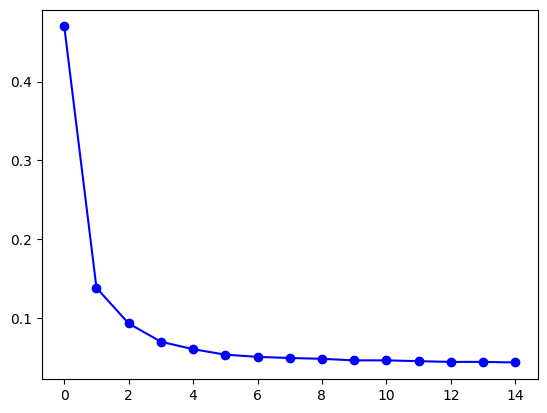

In [9]:
num_epochs = 15
losses = []
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))  # Major ticks every 0.1
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.01))  # Minor ticks every 0.01
for epoch in tqdm(range(num_epochs)):
    plt.ylim(bottom=0.0) # , top=0.8)
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))  # Major ticks every 0.1
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.01))  # Minor ticks every 0.01
    plt.grid(which='both', axis='y')
    plt.show()
    model.train()
    avg_loss = 0
    for images, _ in train_loader:
        t = torch.randint(0, time, (len(images),))
        noisy_images, noise = forward_diffuse(images, t)
        noisy_images, noise = noisy_images.to(device), noise.to(device)
            
        output = model(noisy_images, t.to(device))
        loss = criterion(output, noise)
        avg_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = avg_loss / len(train_loader)
    losses.append(avg_loss)
    plt.plot(losses, marker='o', linestyle='-', color='b', label='Loss')
    clear_output(wait=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2170908..2.880166].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2170908..2.880166].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1154478..2.7853858].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9739387..2.6540256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8037517..2.4968174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6110446..2.3198614].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3995495..2.1269667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1715348..1.931615].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9634768..1.7326673].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.750906.

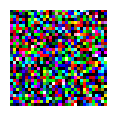

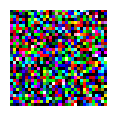

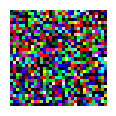

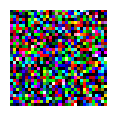

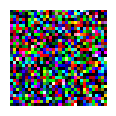

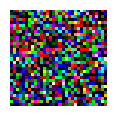

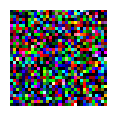

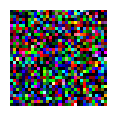

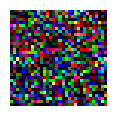

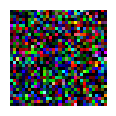

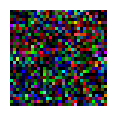

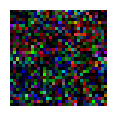

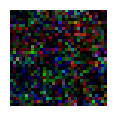

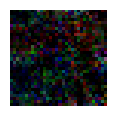

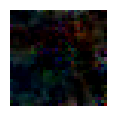

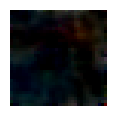

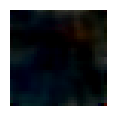

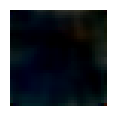

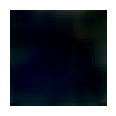

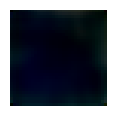

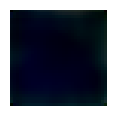

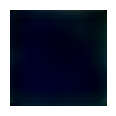

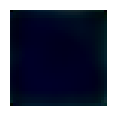

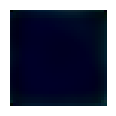

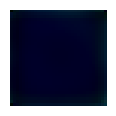

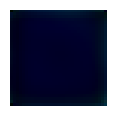

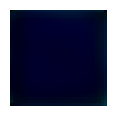

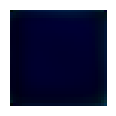

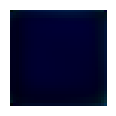

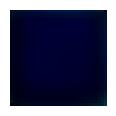

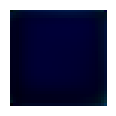

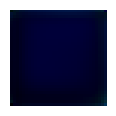

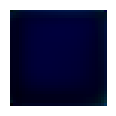

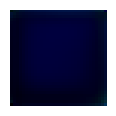

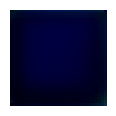

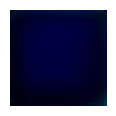

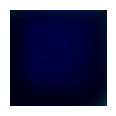

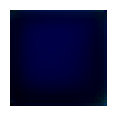

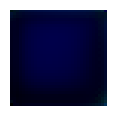

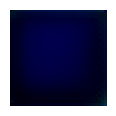

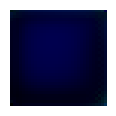

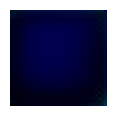

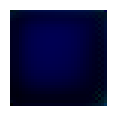

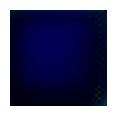

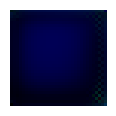

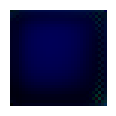

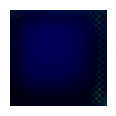

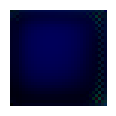

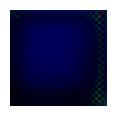

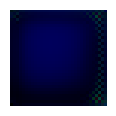

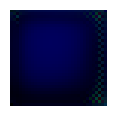

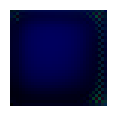

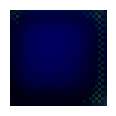

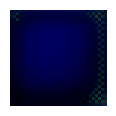

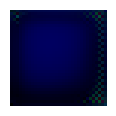

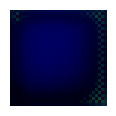

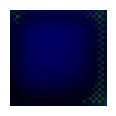

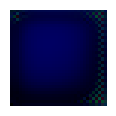

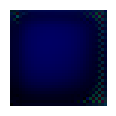

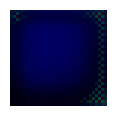

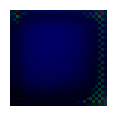

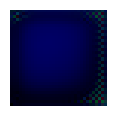

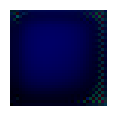

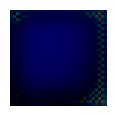

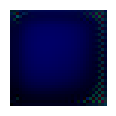

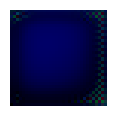

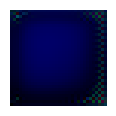

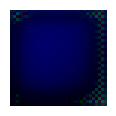

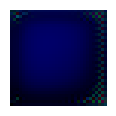

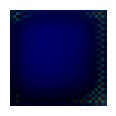

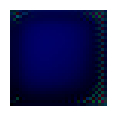

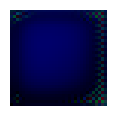

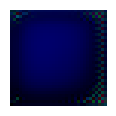

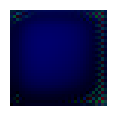

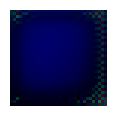

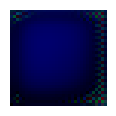

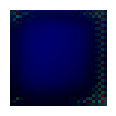

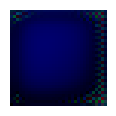

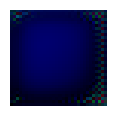

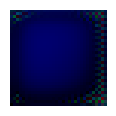

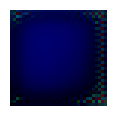

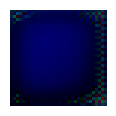

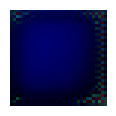

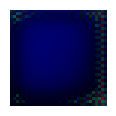

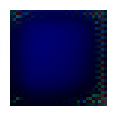

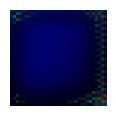

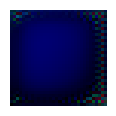

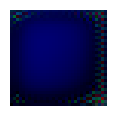

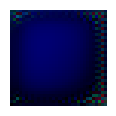

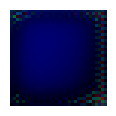

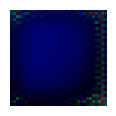

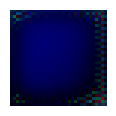

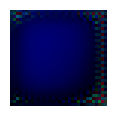

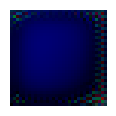

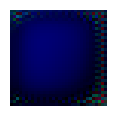

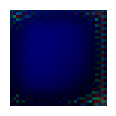

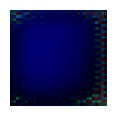

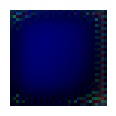

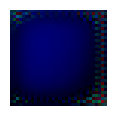

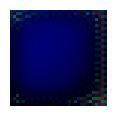

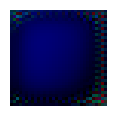

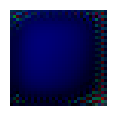

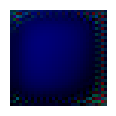

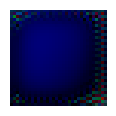

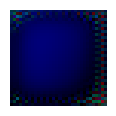

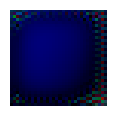

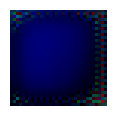

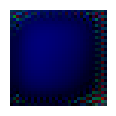

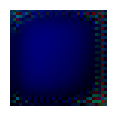

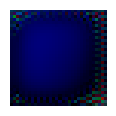

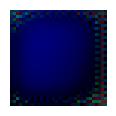

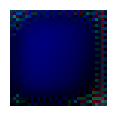

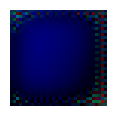

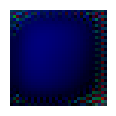

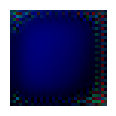

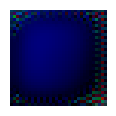

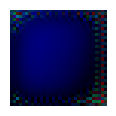

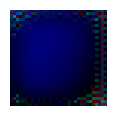

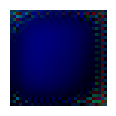

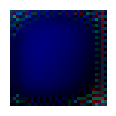

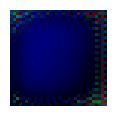

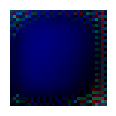

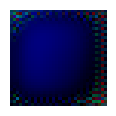

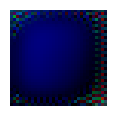

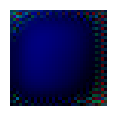

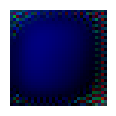

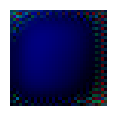

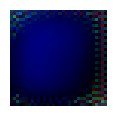

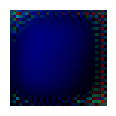

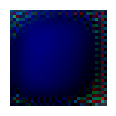

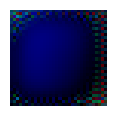

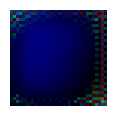

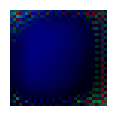

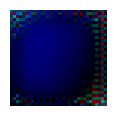

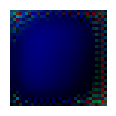

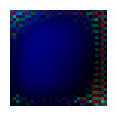

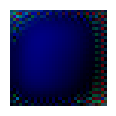

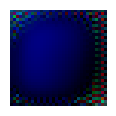

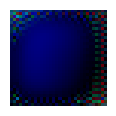

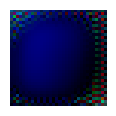

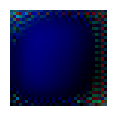

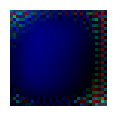

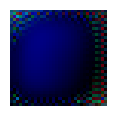

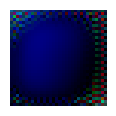

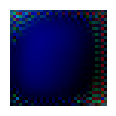

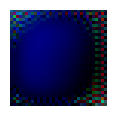

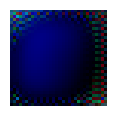

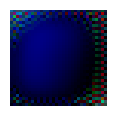

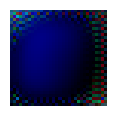

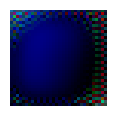

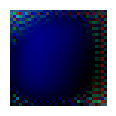

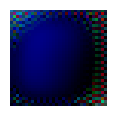

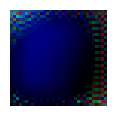

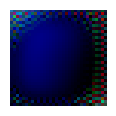

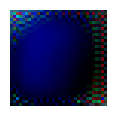

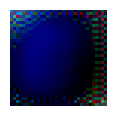

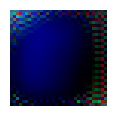

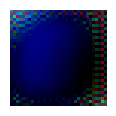

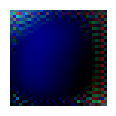

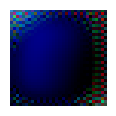

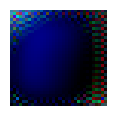

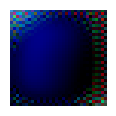

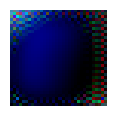

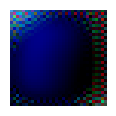

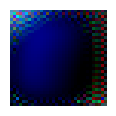

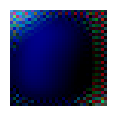

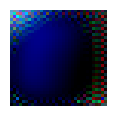

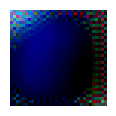

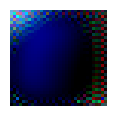

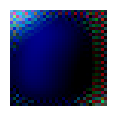

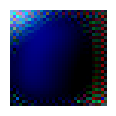

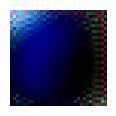

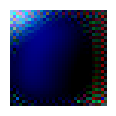

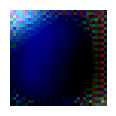

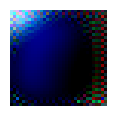

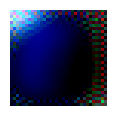

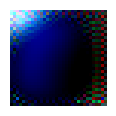

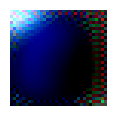

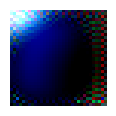

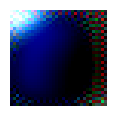

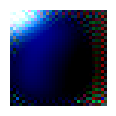

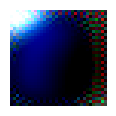

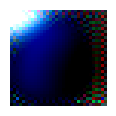

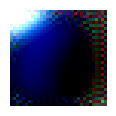

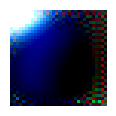

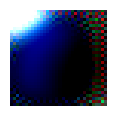

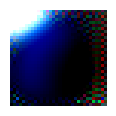

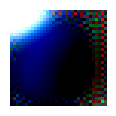

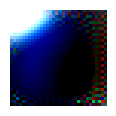

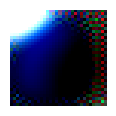

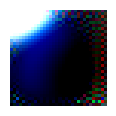

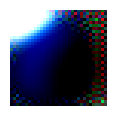

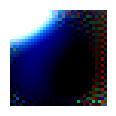

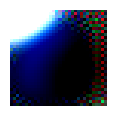

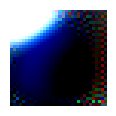

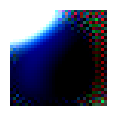

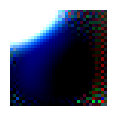

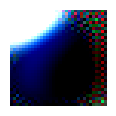

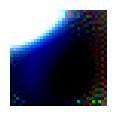

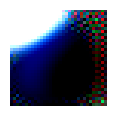

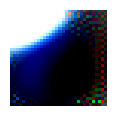

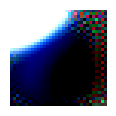

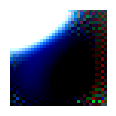

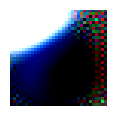

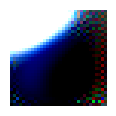

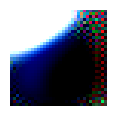

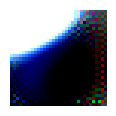

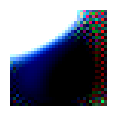

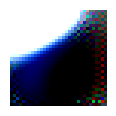

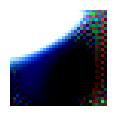

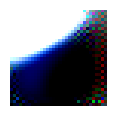

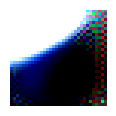

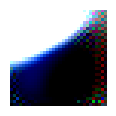

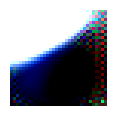

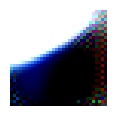

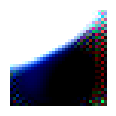

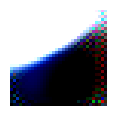

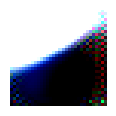

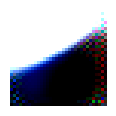

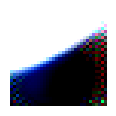

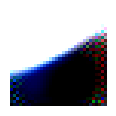

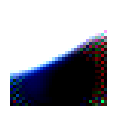

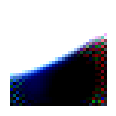

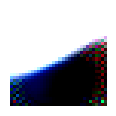

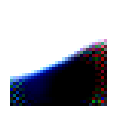

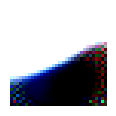

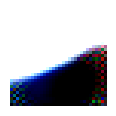

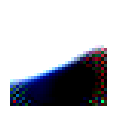

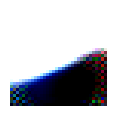

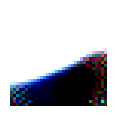

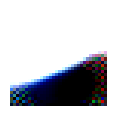

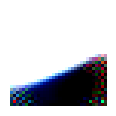

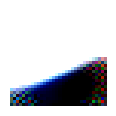

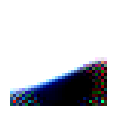

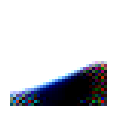

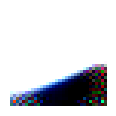

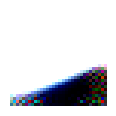

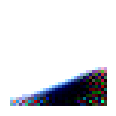

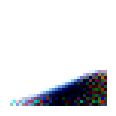

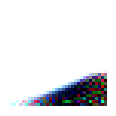

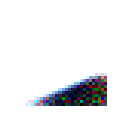

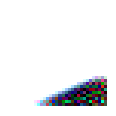

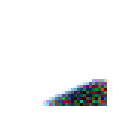

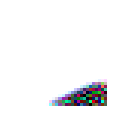

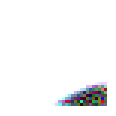

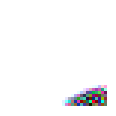

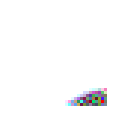

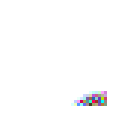

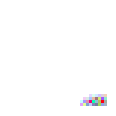

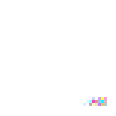

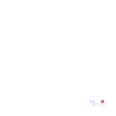

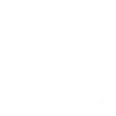

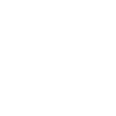

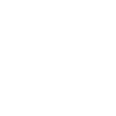

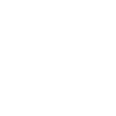

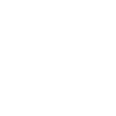

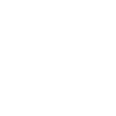

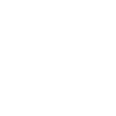

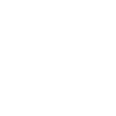

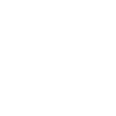

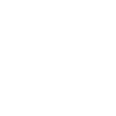

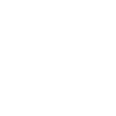

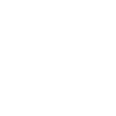

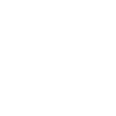

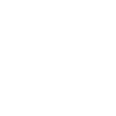

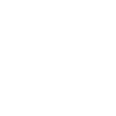

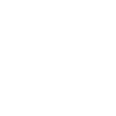

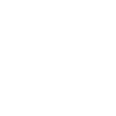

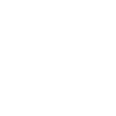

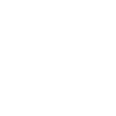

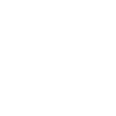

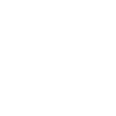

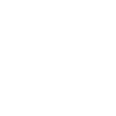

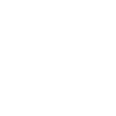

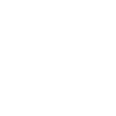

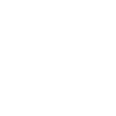

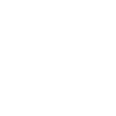

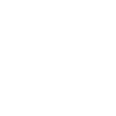

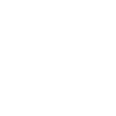

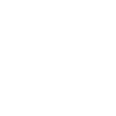

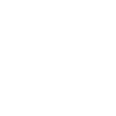

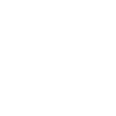

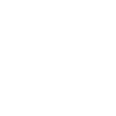

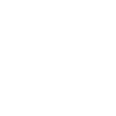

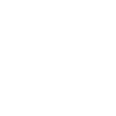

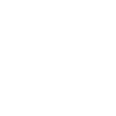

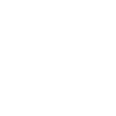

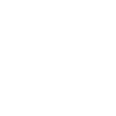

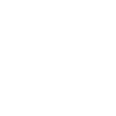

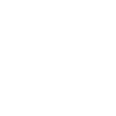

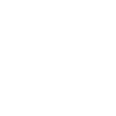

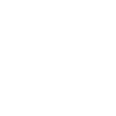

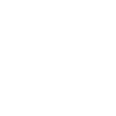

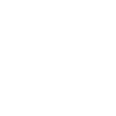

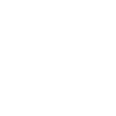

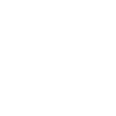

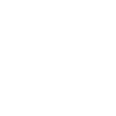

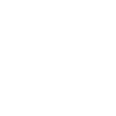

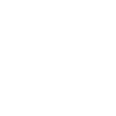

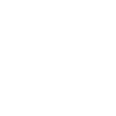

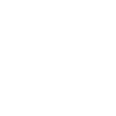

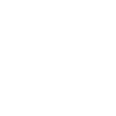

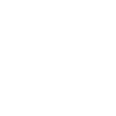

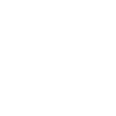

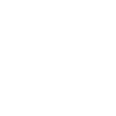

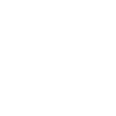

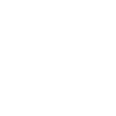

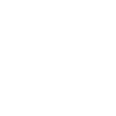

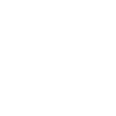

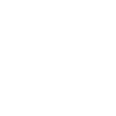

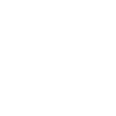

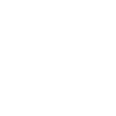

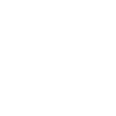

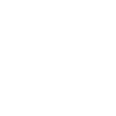

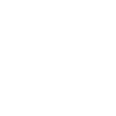

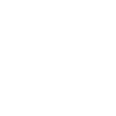

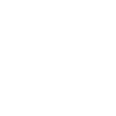

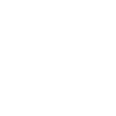

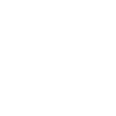

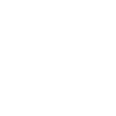

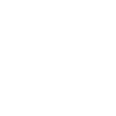

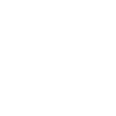

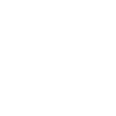

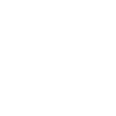

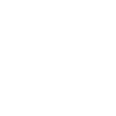

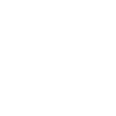

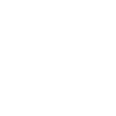

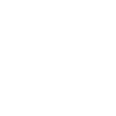

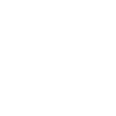

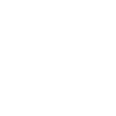

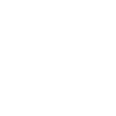

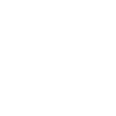

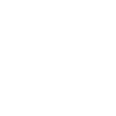

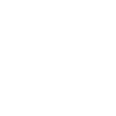

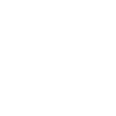

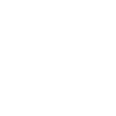

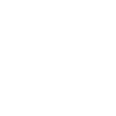

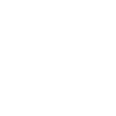

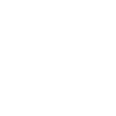

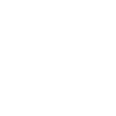

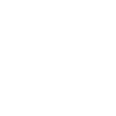

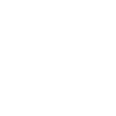

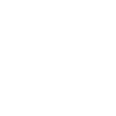

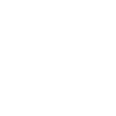

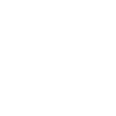

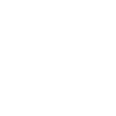

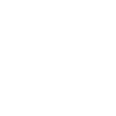

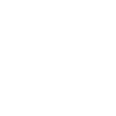

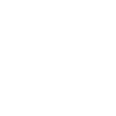

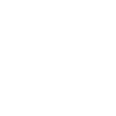

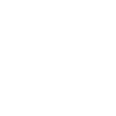

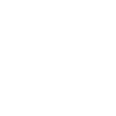

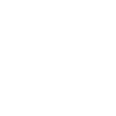

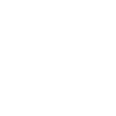

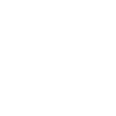

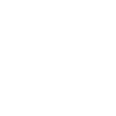

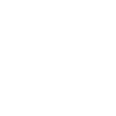

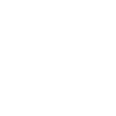

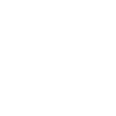

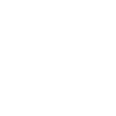

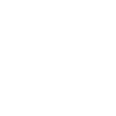

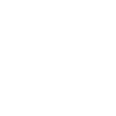

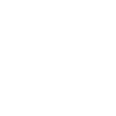

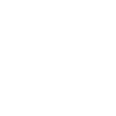

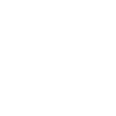

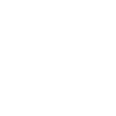

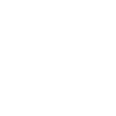

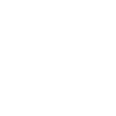

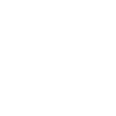

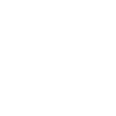

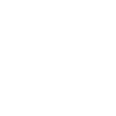

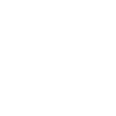

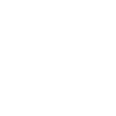

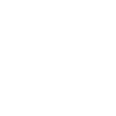

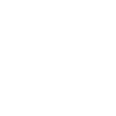

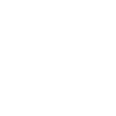

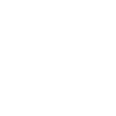

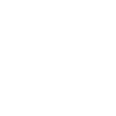

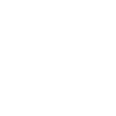

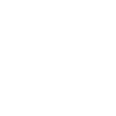

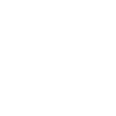

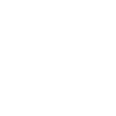

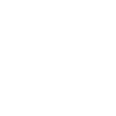

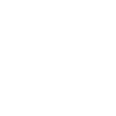

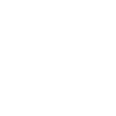

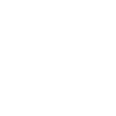

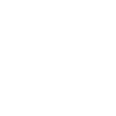

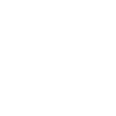

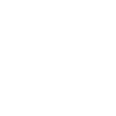

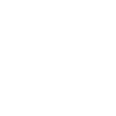

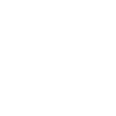

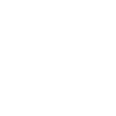

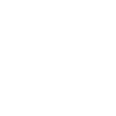

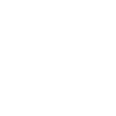

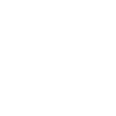

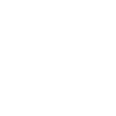

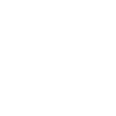

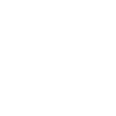

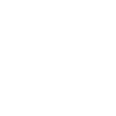

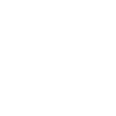

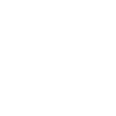

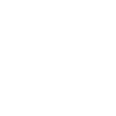

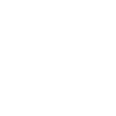

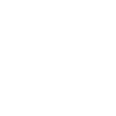

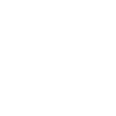

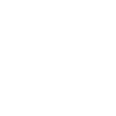

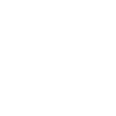

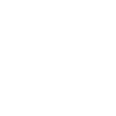

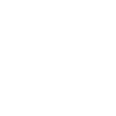

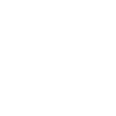

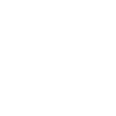

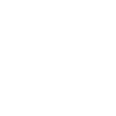

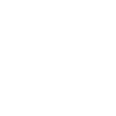

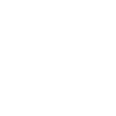

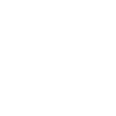

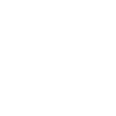

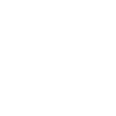

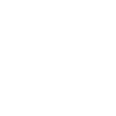

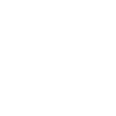

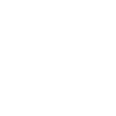

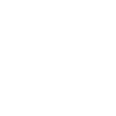

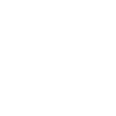

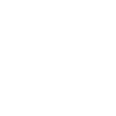

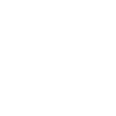

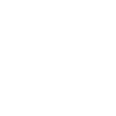

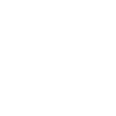

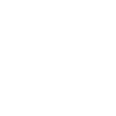

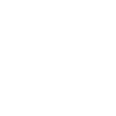

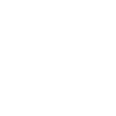

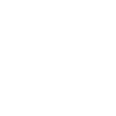

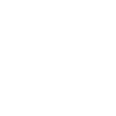

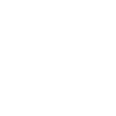

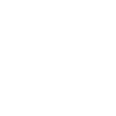

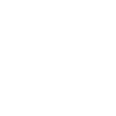

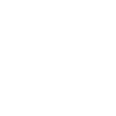

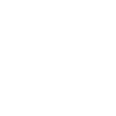

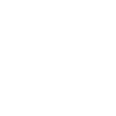

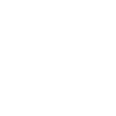

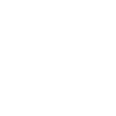

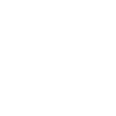

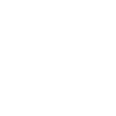

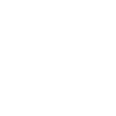

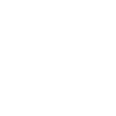

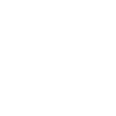

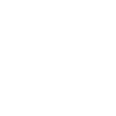

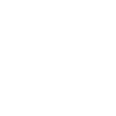

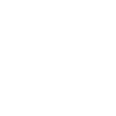

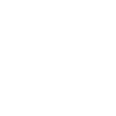

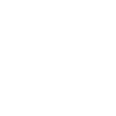

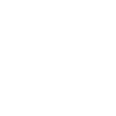

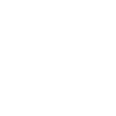

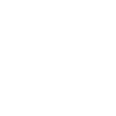

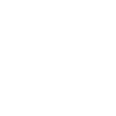

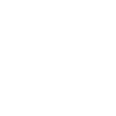

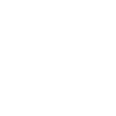

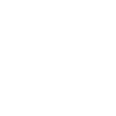

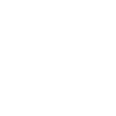

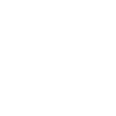

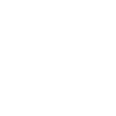

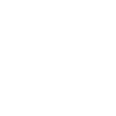

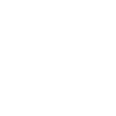

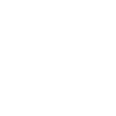

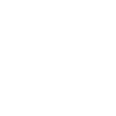

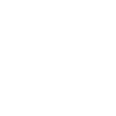

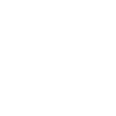

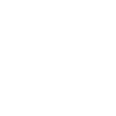

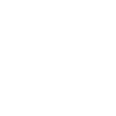

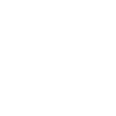

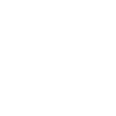

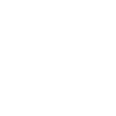

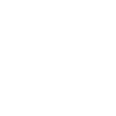

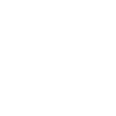

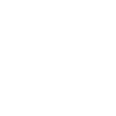

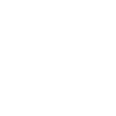

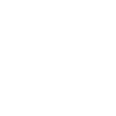

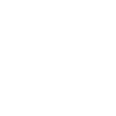

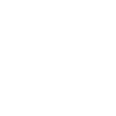

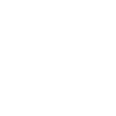

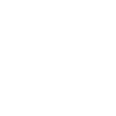

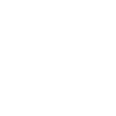

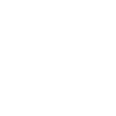

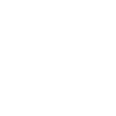

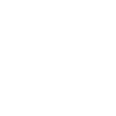

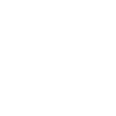

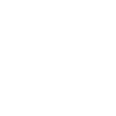

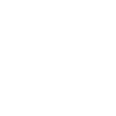

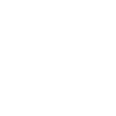

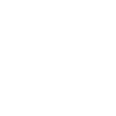

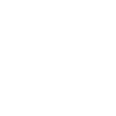

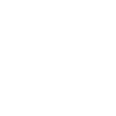

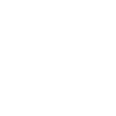

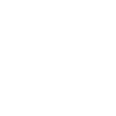

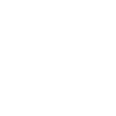

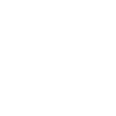

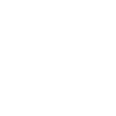

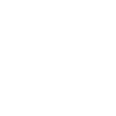

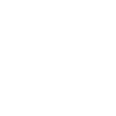

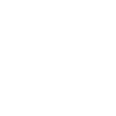

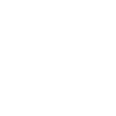

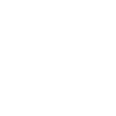

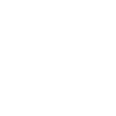

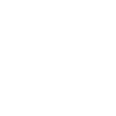

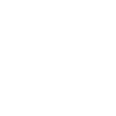

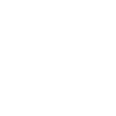

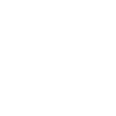

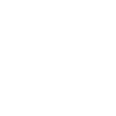

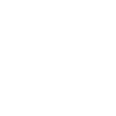

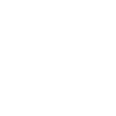

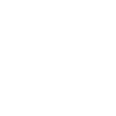

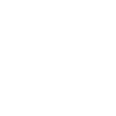

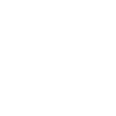

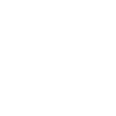

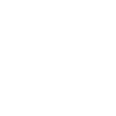

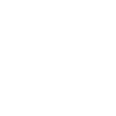

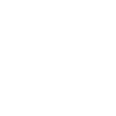

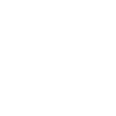

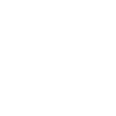

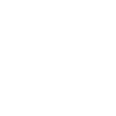

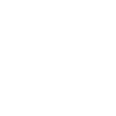

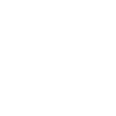

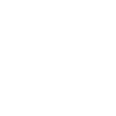

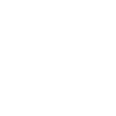

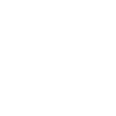

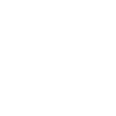

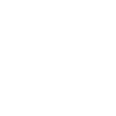

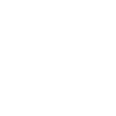

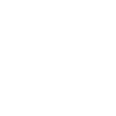

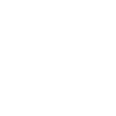

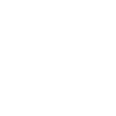

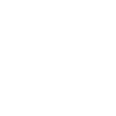

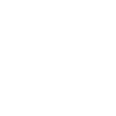

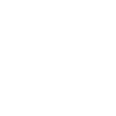

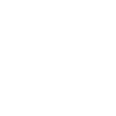

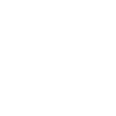

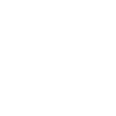

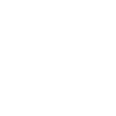

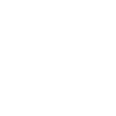

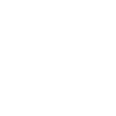

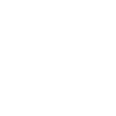

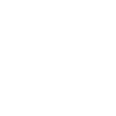

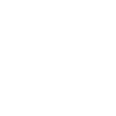

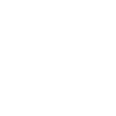

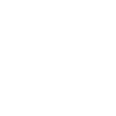

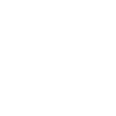

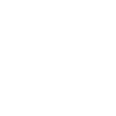

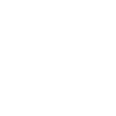

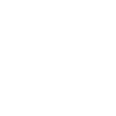

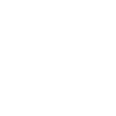

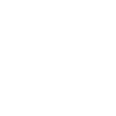

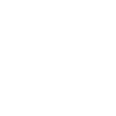

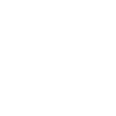

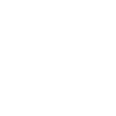

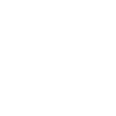

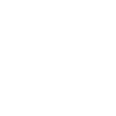

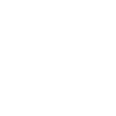

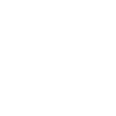

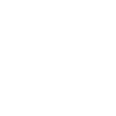

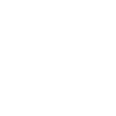

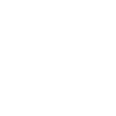

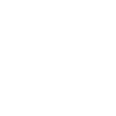

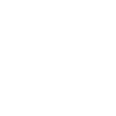

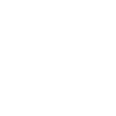

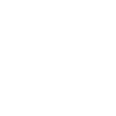

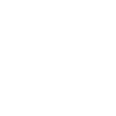

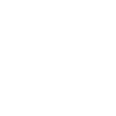

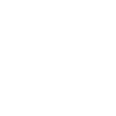

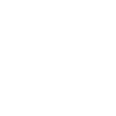

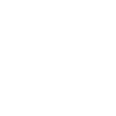

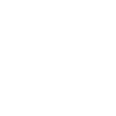

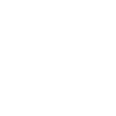

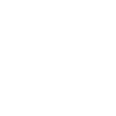

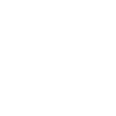

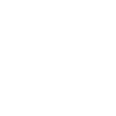

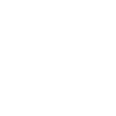

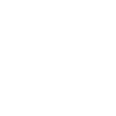

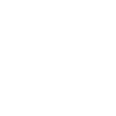

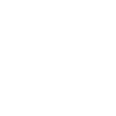

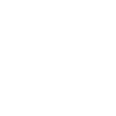

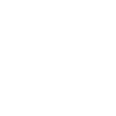

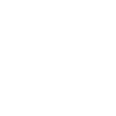

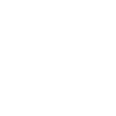

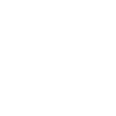

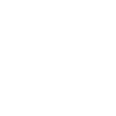

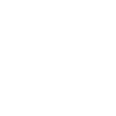

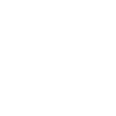

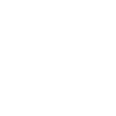

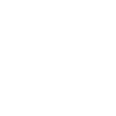

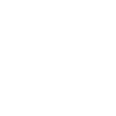

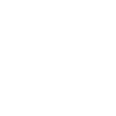

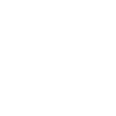

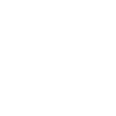

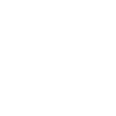

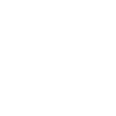

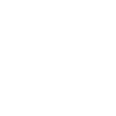

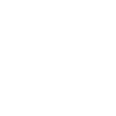

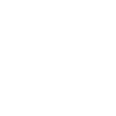

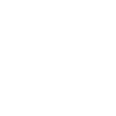

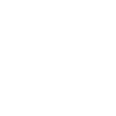

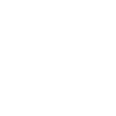

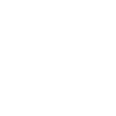

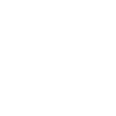

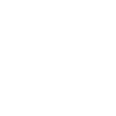

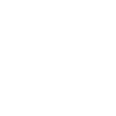

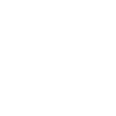

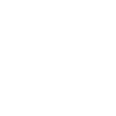

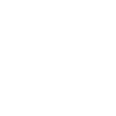

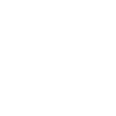

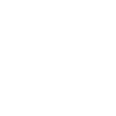

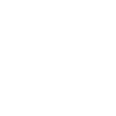

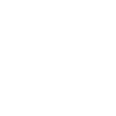

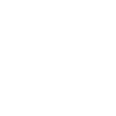

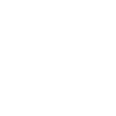

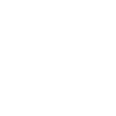

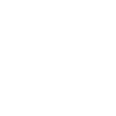

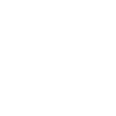

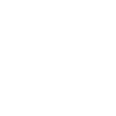

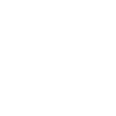

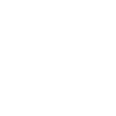

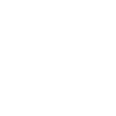

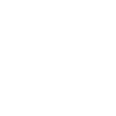

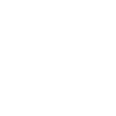

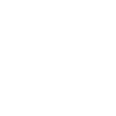

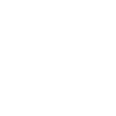

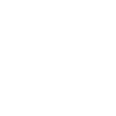

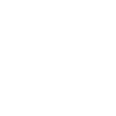

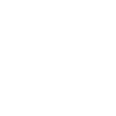

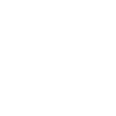

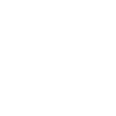

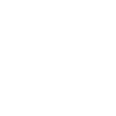

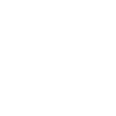

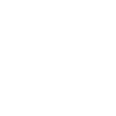

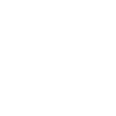

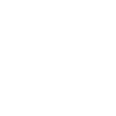

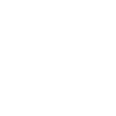

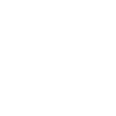

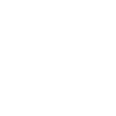

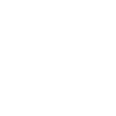

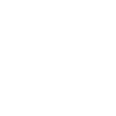

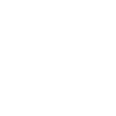

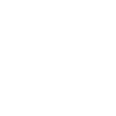

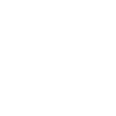

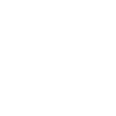

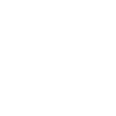

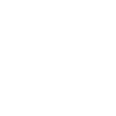

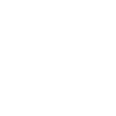

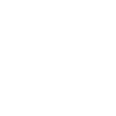

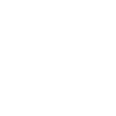

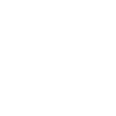

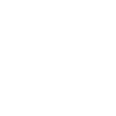

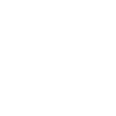

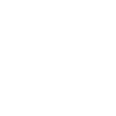

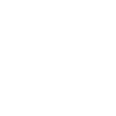

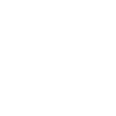

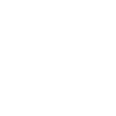

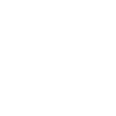

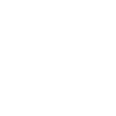

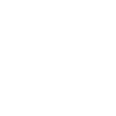

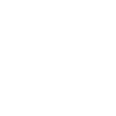

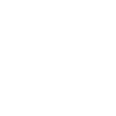

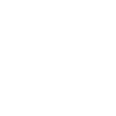

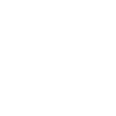

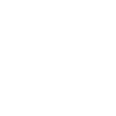

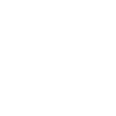

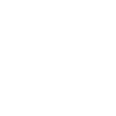

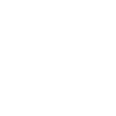

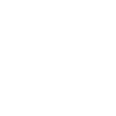

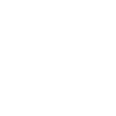

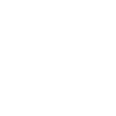

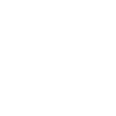

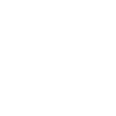

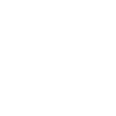

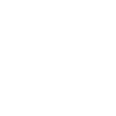

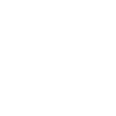

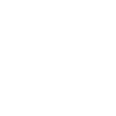

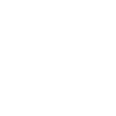

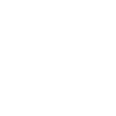

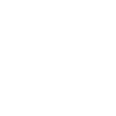

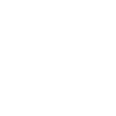

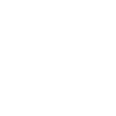

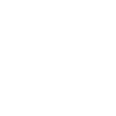

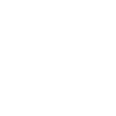

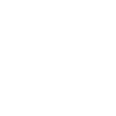

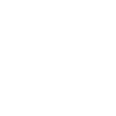

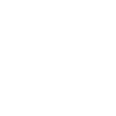

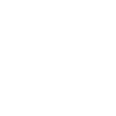

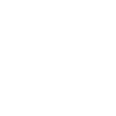

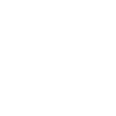

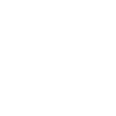

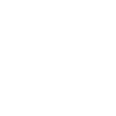

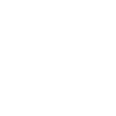

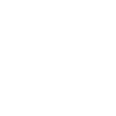

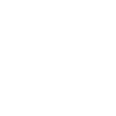

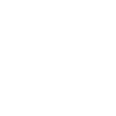

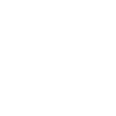

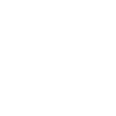

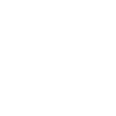

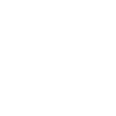

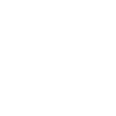

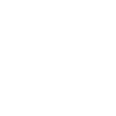

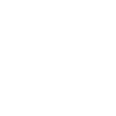

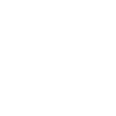

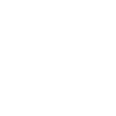

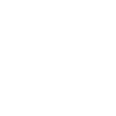

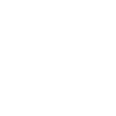

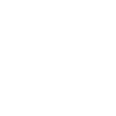

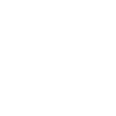

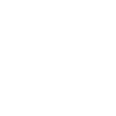

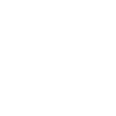

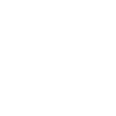

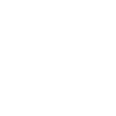

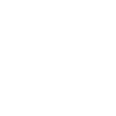

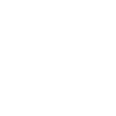

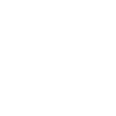

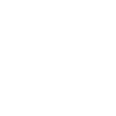

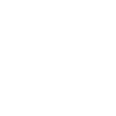

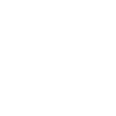

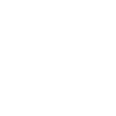

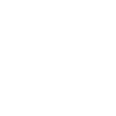

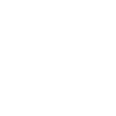

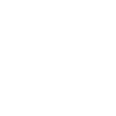

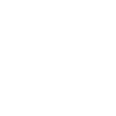

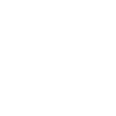

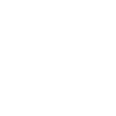

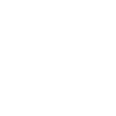

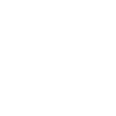

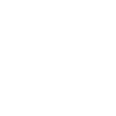

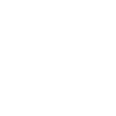

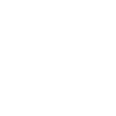

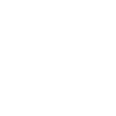

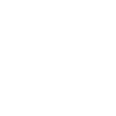

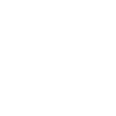

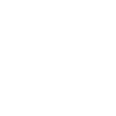

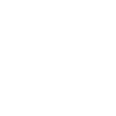

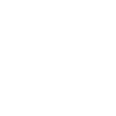

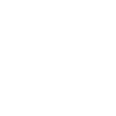

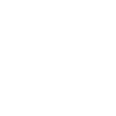

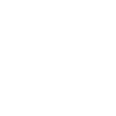

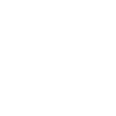

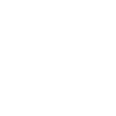

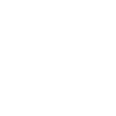

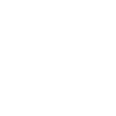

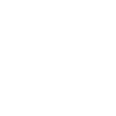

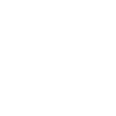

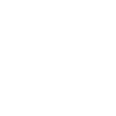

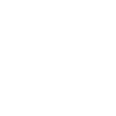

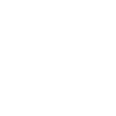

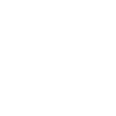

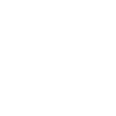

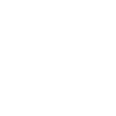

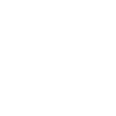

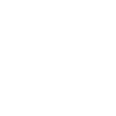

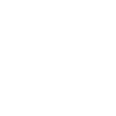

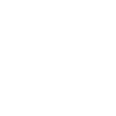

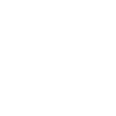

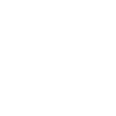

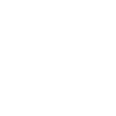

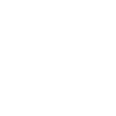

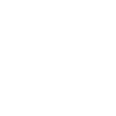

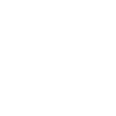

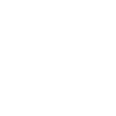

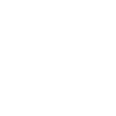

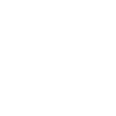

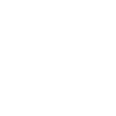

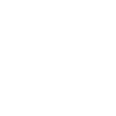

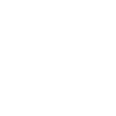

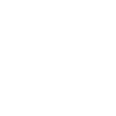

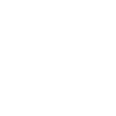

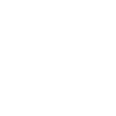

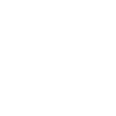

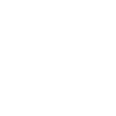

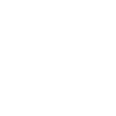

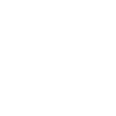

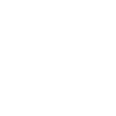

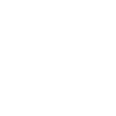

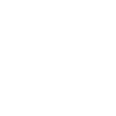

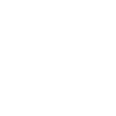

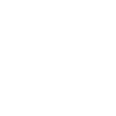

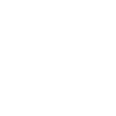

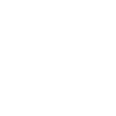

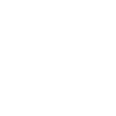

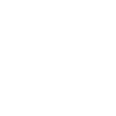

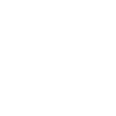

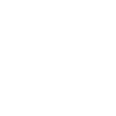

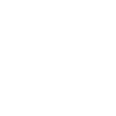

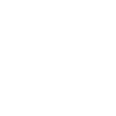

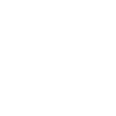

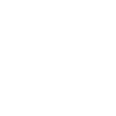

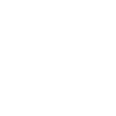

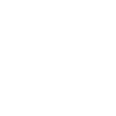

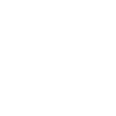

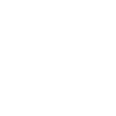

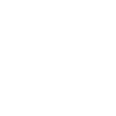

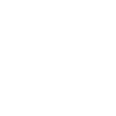

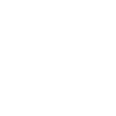

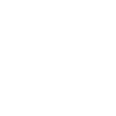

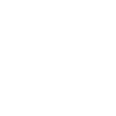

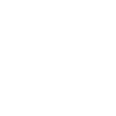

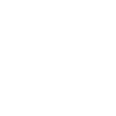

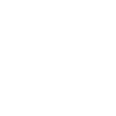

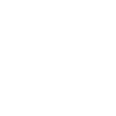

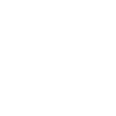

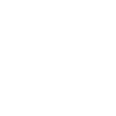

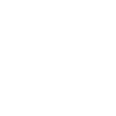

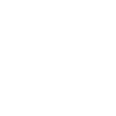

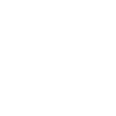

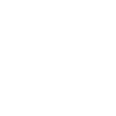

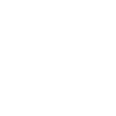

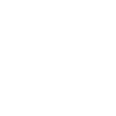

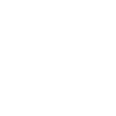

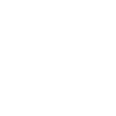

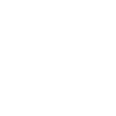

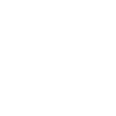

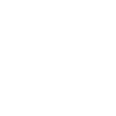

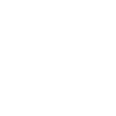

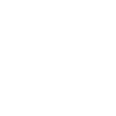

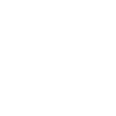

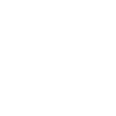

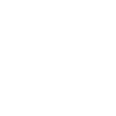

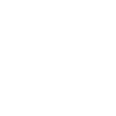

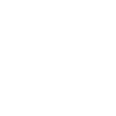

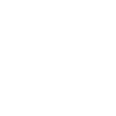

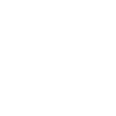

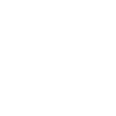

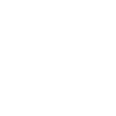

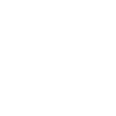

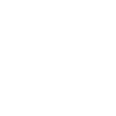

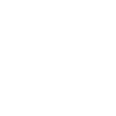

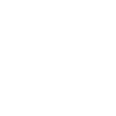

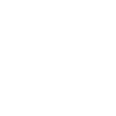

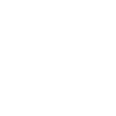

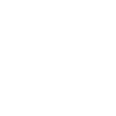

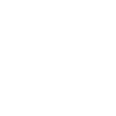

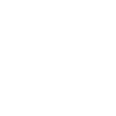

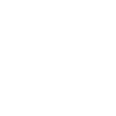

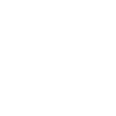

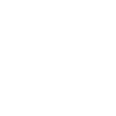

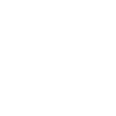

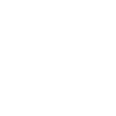

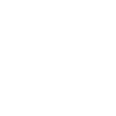

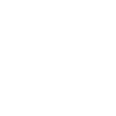

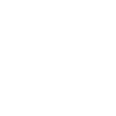

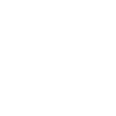

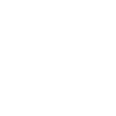

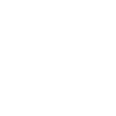

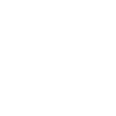

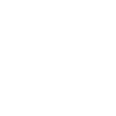

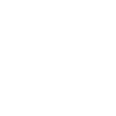

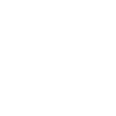

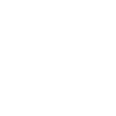

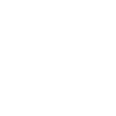

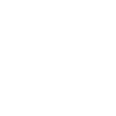

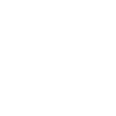

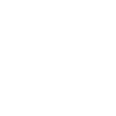

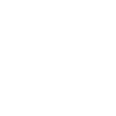

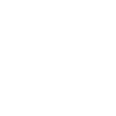

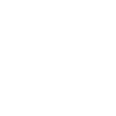

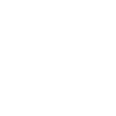

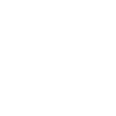

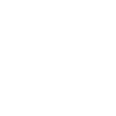

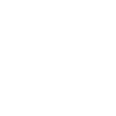

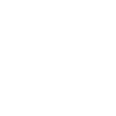

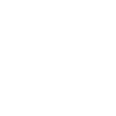

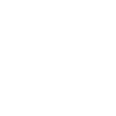

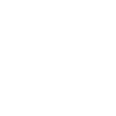

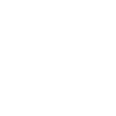

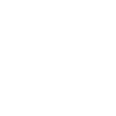

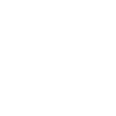

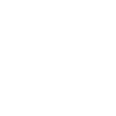

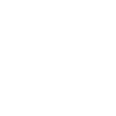

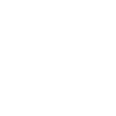

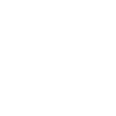

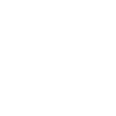

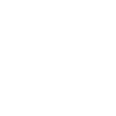

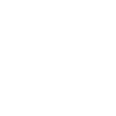

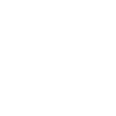

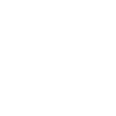

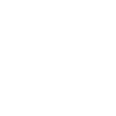

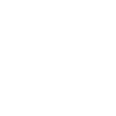

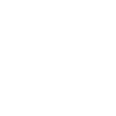

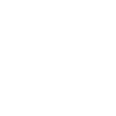

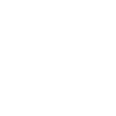

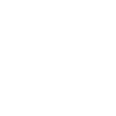

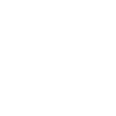

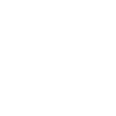

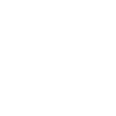

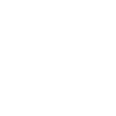

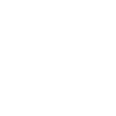

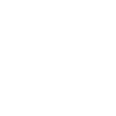

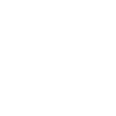

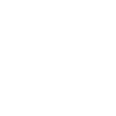

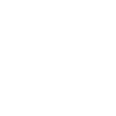

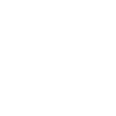

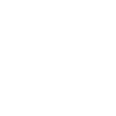

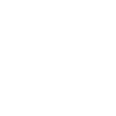

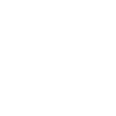

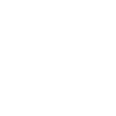

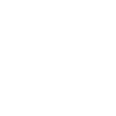

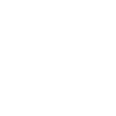

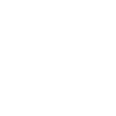

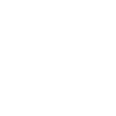

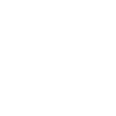

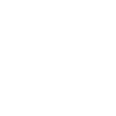

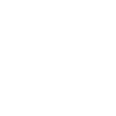

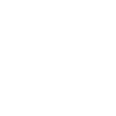

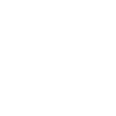

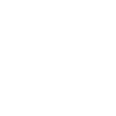

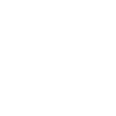

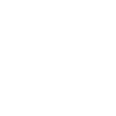

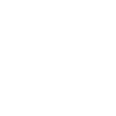

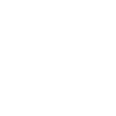

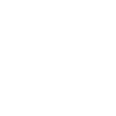

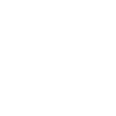

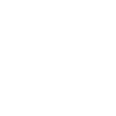

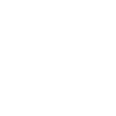

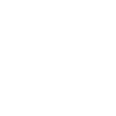

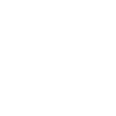

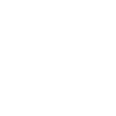

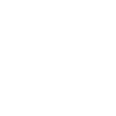

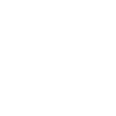

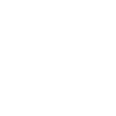

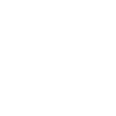

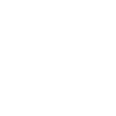

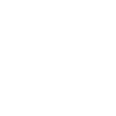

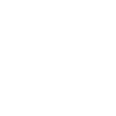

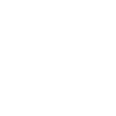

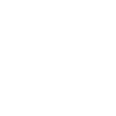

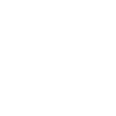

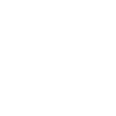

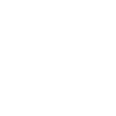

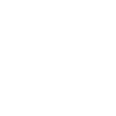

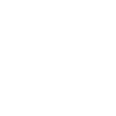

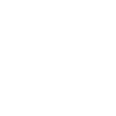

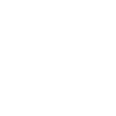

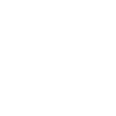

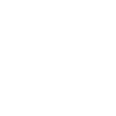

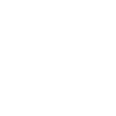

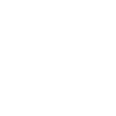

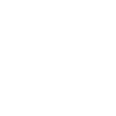

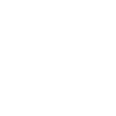

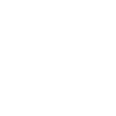

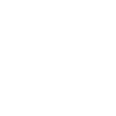

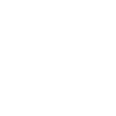

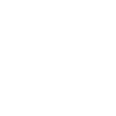

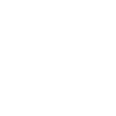

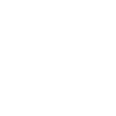

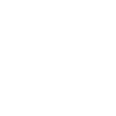

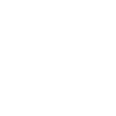

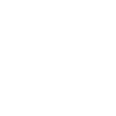

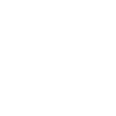

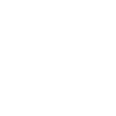

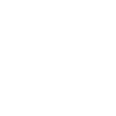

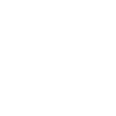

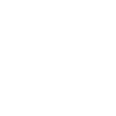

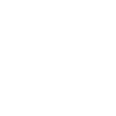

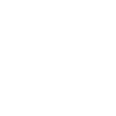

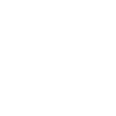

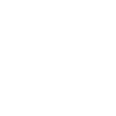

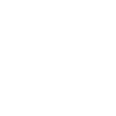

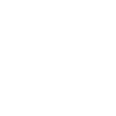

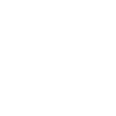

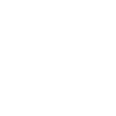

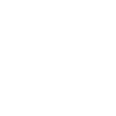

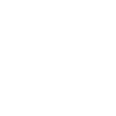

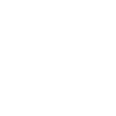

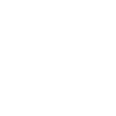

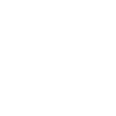

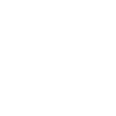

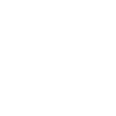

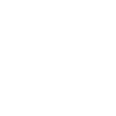

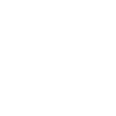

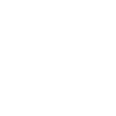

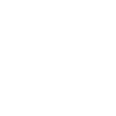

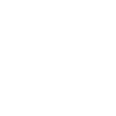

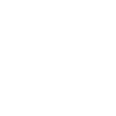

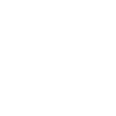

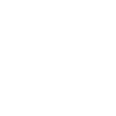

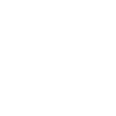

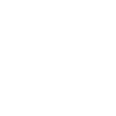

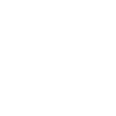

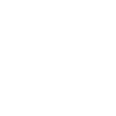

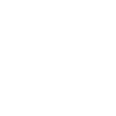

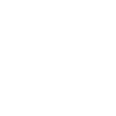

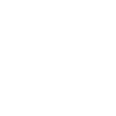

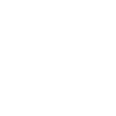

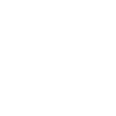

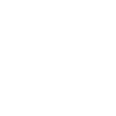

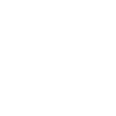

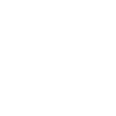

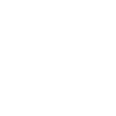

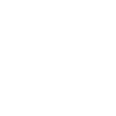

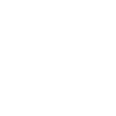

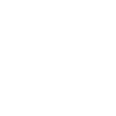

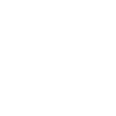

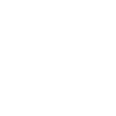

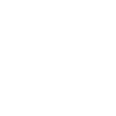

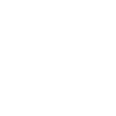

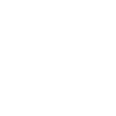

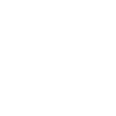

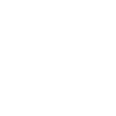

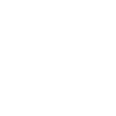

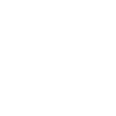

In [12]:
with torch.no_grad():
    test_image = torch.randn((1, 3, 32, 32)).to(device)
    plot_image(test_image[0].cpu())
    for t in range(time):
        noise = model(test_image, torch.tensor([t]).to(device))
        alpha = schedule[t]
        test_image = (test_image - torch.sqrt(1 - alpha) * noise) / torch.sqrt(alpha)
        plot_image(test_image[0].cpu())